In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, auc, roc_curve
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier



import sklearn
import ssl
import os
import warnings
warnings.filterwarnings('ignore')


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow
tensorflow.compat.v1.enable_eager_execution()

import tensorflow_hub as hub
from keras.layers import LSTM, embeddings, Dense, Embedding
import keras
import tensorflow as tf


Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [2]:

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joselopez/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
df=pd.read_csv('./drugsCom_raw/drugsComTrain_raw.tsv', sep='\t',index_col=0 )

In [4]:
df.isna().sum()


drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [5]:
df=df[['review','rating']]

In [6]:
df.sample(5)

,review,rating
14557,"""I had always &quot;played&#039; with pills bu...",10.0
185059,"""Hi all, I only just picked up the prescriptio...",10.0
56227,"""Started my humira on Thursday and was suicida...",1.0
19558,"""Lyrica is the best medication for generalized...",10.0
70106,"""Diagnosed in Feb of 2015 and tried 2 other dr...",9.0


In [7]:
df.rating.drop_duplicates().values

array([ 9.,  8.,  5.,  2.,  1., 10.,  4.,  3.,  7.,  6.])

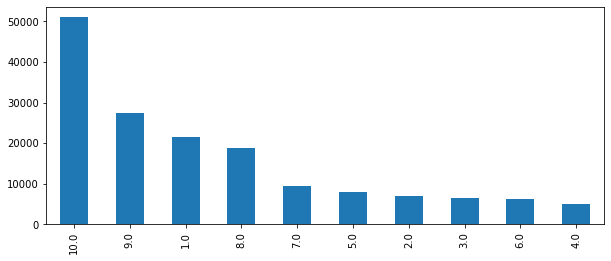

In [8]:
plt.figure(figsize=(10,4))
df.rating.value_counts().plot(kind='bar');

In [9]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [10]:
stop=stopword_list

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


In [11]:
df['review']=df['review'].apply(remove_stopwords)


In [12]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^A-Za-z0-9À-ÖØ-öø-ÿ\s]'
    text=re.sub(pattern,'',text)
    text=re.sub(r'\n', '', text)
    return text

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text= remove_special_characters(text)
    text=re.sub(r"(?<=\w)([A-Z])", r" \1", text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

In [13]:
df.sample(5)

,review,rating
55939,medication helped panic attacks anxiety still...,7.0
228156,23 years old got Implanon inserted October 20...,5.0
171709,I 19 years old suffered depression since 11 ...,10.0
222939,Topamax 4 years brain tumor migraines seizure...,10.0
170124,Took 25mg gained 9lbs 2weeks hard wake mornin...,8.0


In [14]:
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

In [15]:
df['review']=df['review'].apply(simple_stemmer)
df.sample(3)

,review,rating
62167,celexa depress thirteen year total six first t...,7.0
15875,first time took medic last month 1st day perio...,8.0
212001,cognit side effect weren bad go medic made dev...,4.0


# Encoding the input for a LSTM


In [16]:
df.sample(3)

,review,rating
64782,zoloft 20 year medic field far someon extens e...,8.0
146978,psychiatrist prescrib 15 xanax 05mg per month ...,10.0
231739,help sleep run thought wake panick,8.0


In [17]:
X=df['review'].values
y=df['rating'].values

In [18]:
y = keras.utils.to_categorical(y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [20]:
X_train.shape, X_test.shape, y_train.shape

((129037,), (32260,), (129037, 11))

In [ ]:
vectorizer = TfidfVectorizer(min_df=.2)
X_train = vectorizer.fit_transform(X_train).toarray() # sparse also works but Explanation slicing is not yet supported
X_test = vectorizer.transform(X_test).toarray()

In [22]:
X_train[0].shape

(61,)

In [23]:
X_train[20].shape, y_train.shape

((61,), (129037, 11))

In [24]:
model = keras.Sequential()
model.add(Embedding(61, 32, input_length=61))
model.add(LSTM(4))
model.add(Dense(11, activation='softmax'))
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[keras.metrics.AUC()])


2022-03-14 16:31:54.293076: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-14 16:31:54.294380: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [31]:
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 61, 32)            1952      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 592       
_________________________________________________________________
dense_1 (Dense)              (None, 11)                55        
Total params: 2,599
Trainable params: 2,599
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
history=model.fit(X_train, y_train, epochs=10, batch_size=512,validation_data=(X_test, y_test))

Train on 129037 samples, validate on 32260 samples
Epoch 1/10
129037/129037 [==============================] - 39s 304us/step - loss: 2.0266 - auc_1: 0.7537 - val_loss: 2.0053 - val_auc_1: 0.7583
Epoch 2/10
129037/129037 [==============================] - 40s 306us/step - loss: 2.0035 - auc_1: 0.7589 - val_loss: 2.0040 - val_auc_1: 0.7591
Epoch 3/10
129037/129037 [==============================] - 40s 312us/step - loss: 2.0035 - auc_1: 0.7586 - val_loss: 2.0036 - val_auc_1: 0.7581
Epoch 4/10
129037/129037 [==============================] - 41s 320us/step - loss: 2.0032 - auc_1: 0.7586 - val_loss: 2.0033 - val_auc_1: 0.7586
Epoch 5/10
129037/129037 [==============================] - 41s 318us/step - loss: 2.0032 - auc_1: 0.7587 - val_loss: 2.0038 - val_auc_1: 0.7582
Epoch 6/10
129037/129037 [==============================] - 42s 322us/step - loss: 2.0030 - auc_1: 0.7586 - val_loss: 2.0040 - val_auc_1: 0.7590
Epoch 7/10
129037/129037 [==============================] - 41s 319us/step - lo

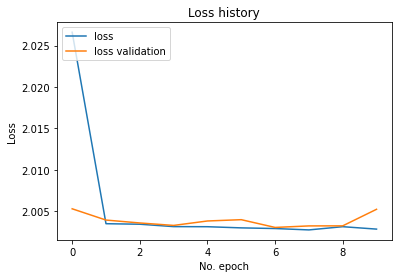

In [64]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='loss validation')
plt.title('Loss history')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [28]:
history.history

{'val_loss': [2.005315742120193,
  2.003957056038437,
  2.003606838848897,
  2.0033111306797697,
  2.003846123110635,
  2.0040034277573624,
  2.003066870815918,
  2.003251270159977,
  2.0032594201288383,
  2.0052553973135856],
 'val_auc_1': [0.7583394050598145,
  0.7590540051460266,
  0.7581210136413574,
  0.7586401700973511,
  0.7581735849380493,
  0.7589715123176575,
  0.7590848207473755,
  0.7579828500747681,
  0.7590813636779785,
  0.7570174932479858],
 'loss': [2.0266064597257776,
  2.003518258729782,
  2.00345472414726,
  2.0031658356362505,
  2.003154614558957,
  2.003014790066447,
  2.0029356582911393,
  2.0027685647177575,
  2.003158065530099,
  2.002865541561186],
 'auc_1': [0.753739,
  0.75889856,
  0.75855863,
  0.75864995,
  0.758718,
  0.7586088,
  0.7585751,
  0.758731,
  0.7586392,
  0.7586791]}

In [39]:
y_pred=model.predict(X_test)

In [55]:
y_pred_ = tf.one_hot(tf.argmax(y_pred, axis=1), depth = 11)

In [61]:
y_pred_=y_pred_.numpy()

In [65]:
print(sklearn.metrics.classification_report(y_test, y_pred_, digits=5))

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000         0
           1    0.00000   0.00000   0.00000      4388
           2    0.00000   0.00000   0.00000      1386
           3    0.00000   0.00000   0.00000      1293
           4    0.00000   0.00000   0.00000      1009
           5    0.00000   0.00000   0.00000      1552
           6    0.00000   0.00000   0.00000      1271
           7    0.00000   0.00000   0.00000      1895
           8    0.00000   0.00000   0.00000      3818
           9    0.00000   0.00000   0.00000      5522
          10    0.31389   1.00000   0.47780     10126

   micro avg    0.31389   0.31389   0.31389     32260
   macro avg    0.02854   0.09091   0.04344     32260
weighted avg    0.09853   0.31389   0.14998     32260
 samples avg    0.31389   0.31389   0.31389     32260

